# Cincinnati Reds Baseball Analytics Trainee
## Second Round Interview Assessment

Presented by Robert L. Prattico

robertprattico@gmail.com

(514) 260-4247

Monday, October 30, 2023

In this project, we'll be using baseball pitching data to estimate the probability that a given pitch was affected by a dew point level greater than 65 degrees F. We'll be applying a variety of statistical and machine learning methods to solve this use case, while creating a variety of data visualization to illustrate our findings along the way.

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Add your file path below
df=pd.read_csv("C:/Users/rprat/OneDrive/Documents/Interview Projects/Cincinnarti Red Associate Data Analyst Trainee Interview/data.csv")

In [3]:
df

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,...,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,...,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,...,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,...,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,...,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,...,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,...,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,...,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,...,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,...,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


## Part I: Identifying Outliers with Data Visualization

Let's visualize where a given pitch type is typically supposed to land in the plane above home plate. By doing so, we can identify outliers that could have occured because of conditions stemming a high dew point. 

In [4]:
#View all pitch types
print([i for i in df["PITCH_TYPE_TRACKED_KEY"].unique()])

['FB', 'SL', 'UN', 'SF', 'SI', 'SW', 'CH', 'CB', 'CF', 'KN']


In [5]:
pitch_type_dict={"FB":"Fastball","SL":"Slider","UN":"Unidentified","KN":"Knuckleball","CB":"Curveball","CH":"Changeup","SI":"Sinker","CF":"Cut Fastball","SF":"Split Finger","SW":"Sweeper"}

In [6]:
def pitch_type_landing_spots(pitch_type):
    df_pitch=df[(df["PITCH_TYPE_TRACKED_KEY"]==pitch_type)]
    left_hand_df=df_pitch[(df_pitch["THROW_SIDE_KEY"]=="L")]
    right_hand_df=df_pitch[(df_pitch["THROW_SIDE_KEY"]=="R")]

    fig=plt.figure(figsize=(25,10))
    ax=fig.add_subplot(1,2,2)
    
    #Distinguish pitches based on handedness
    left_pitches=ax.scatter(left_hand_df["PLATE_X"],left_hand_df["PLATE_Z"],color="lightblue")
    right_pitches=ax.scatter(right_hand_df["PLATE_X"],right_hand_df["PLATE_Z"],color="lightcoral",alpha=0.2)

    ax.spines['left'].set_position(('axes', 0.5))
    ax.spines['bottom'].set_position(('axes', 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlabel('PLATE_X', ha='right', x=1.0)
    ax.set_ylabel('PLATE_Z', ha='right', y=1.0)
    
    plt.legend((left_pitches,right_pitches),("Left-handed Pitches","Right-handed Pitches"))
    plt.title(f"{pitch_type_dict[pitch_type]} Pitch Placements Above Home Plate", fontsize=20)
    plt.show()

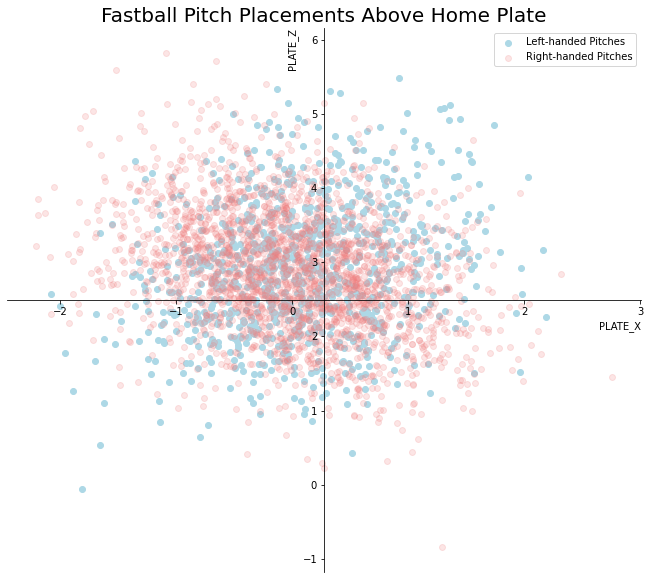

In [7]:
pitch_type_landing_spots("FB") #Insert any pitch type

Let's narrow our plot down to a specific pitcher, in case a given player has a specific tendency or style throwing a given pitch type

In [8]:
def pitcher_pitchtype_plot(pitcher, pitch_type):
    df_pitch=df[(df["PITCH_TYPE_TRACKED_KEY"]==pitch_type)&(df["PITCHER_KEY"]==pitcher)]

    fig=plt.figure(figsize=(25,10))
    ax=fig.add_subplot(1,2,2)
    
    plot_pitches=ax.scatter(df_pitch["PLATE_X"],df_pitch["PLATE_Z"],color="lightblue")

    ax.spines['left'].set_position(('axes', 0.5))
    ax.spines['bottom'].set_position(('axes', 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlabel('PLATE_X', ha='right', x=1.0)
    ax.set_ylabel('PLATE_Z', ha='right', y=1.0)
    
    plt.title(f"Pitcher {pitcher} {pitch_type_dict[pitch_type]} Pitch Placements Above Home Plate", fontsize=20)
    plt.show()
    
#A pitcher always pitches with the same hand. No need to consider handedness

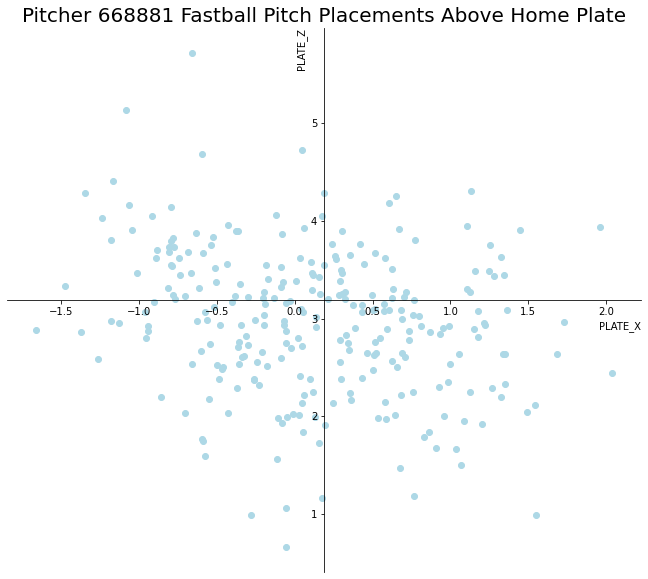

In [9]:
pitcher_pitchtype_plot(668881, "FB") #Insert any pitcher ID or pitch type

Let's highlight the outlier pitches from a specific player's set of pitches of the same type. We'll do this using the interquartile range method of identifying outliers in a dataset. An outlier will be defined as a pitch that is placed beyond the horizontal or vertical range above home plate that is typicaly observed for a pitcher's pitch type.

In [10]:
def pitcher_pitchtype_plot_w_outliers(pitcher, pitch_type):
    df_pitch=df[(df["PITCH_TYPE_TRACKED_KEY"]==pitch_type)&(df["PITCHER_KEY"]==pitcher)]

    fig=plt.figure(figsize=(25,10))
    ax=fig.add_subplot(1,2,2)
    
    #Normal pitches
    plot_pitches=ax.scatter(df_pitch["PLATE_X"],df_pitch["PLATE_Z"],color="lightblue")
    
    #Identify outlier pitches using interquartile range
    #Horizontal outliers
    x=df_pitch["PLATE_X"].sort_values()
    xq1=np.percentile(x,25)
    xq3=np.percentile(x,75)
    xiqr=xq3-xq1
    xlb=xq1-(1.5*xiqr)
    xub=xq3+(1.5*xiqr)
    x_outliers=[i for i in x if i<xlb or i>xub]
    
    #Vertical outliers
    z=df_pitch["PLATE_Z"].sort_values()
    zq1=np.percentile(z,25)
    zq3=np.percentile(z,75)
    ziqr=zq3-zq1
    zlb=zq1-(1.5*ziqr)
    zub=zq3+(1.5*ziqr)
    z_outliers=[i for i in z if i<zlb or i>zub]
    
    outliers_df=df_pitch[df_pitch["PLATE_X"].isin(x_outliers)|df_pitch["PLATE_Z"].isin(z_outliers)]
    
    plot_outliers=ax.scatter(outliers_df["PLATE_X"],outliers_df["PLATE_Z"],color="lightcoral")

    ax.spines['left'].set_position(('axes', 0.5))
    ax.spines['bottom'].set_position(('axes', 0.5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlabel('PLATE_X', ha='right', x=1.0)
    ax.set_ylabel('PLATE_Z', ha='right', y=1.0)
    
    plt.legend((plot_pitches,plot_outliers),("Normal Pitches","Outlier Pitches"))
    plt.title(f"Pitcher {pitcher} {pitch_type_dict[pitch_type]} Pitch Placements Above Home Plate", fontsize=20)
    plt.show()

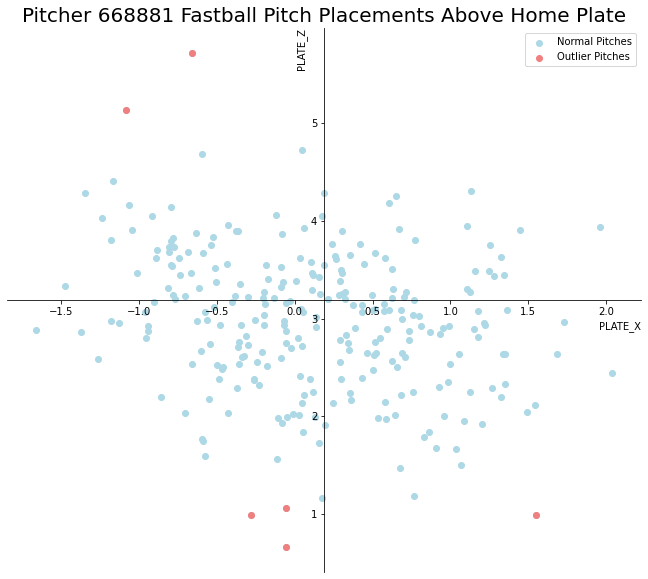

In [11]:
pitcher_pitchtype_plot_w_outliers(668881, "FB") #insert any pitcher ID or pitch type

In [12]:
#Identify outlier pitches in the dataset
def pitcher_pitchtype_outliers(pitcher, pitch_type):
    df_pitch=df[(df["PITCH_TYPE_TRACKED_KEY"]==pitch_type)&(df["PITCHER_KEY"]==pitcher)]

    #Identify outlier pitches using interquartile range
    #Horizontal outliers
    x=df_pitch["PLATE_X"].sort_values()
    xq1=np.percentile(x,25)
    xq3=np.percentile(x,75)
    xiqr=xq3-xq1
    xlb=xq1-(1.5*xiqr)
    xub=xq3+(1.5*xiqr)
    x_outliers=[i for i in x if i<xlb or i>xub]
    
    #Vertical outliers
    z=df_pitch["PLATE_Z"].sort_values()
    zq1=np.percentile(z,25)
    zq3=np.percentile(z,75)
    ziqr=zq3-zq1
    zlb=zq1-(1.5*ziqr)
    zub=zq3+(1.5*ziqr)
    z_outliers=[i for i in z if i<zlb or i>zub]

    #Note outliers and add them to a dataset
    #Normal pitches are noted with 0, outlier pitches are noted with 1
    for i in df_pitch["PLATE_X"]:
        if i in x_outliers:
            df_pitch["Is X Outlier?"]=1
        else:
            df_pitch["Is X Outlier?"]=0
        
    for i in df_pitch["PLATE_Z"]:
        if i in z_outliers:
            df_pitch["Is Z Outlier?"]=1
        else:
            df_pitch["Is Z Outlier?"]=0
    
    df_pitch["Is Outlier?"]=df_pitch["Is X Outlier?"]+df_pitch["Is Z Outlier?"]
    df_pitch=df_pitch.drop(columns=["Is X Outlier?", "Is Z Outlier?"])
    
    return df_pitch

In [13]:
#Iterate across the entire dataset to identify outliers in each pitcher's pitch type, then concate all together
df2=pd.DataFrame(columns=df.columns)

for pitcher in df["PITCHER_KEY"].unique():
    df_pitcher=df[(df["PITCHER_KEY"]==pitcher)]
    for pitch_type in df_pitcher["PITCH_TYPE_TRACKED_KEY"].unique():
        df3=pitcher_pitchtype_outliers(pitcher,pitch_type)
        df2=pd.concat([df2,df3],axis=0,ignore_index=True)

<ipython-input-12-694d8d5ec1d0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitch["Is X Outlier?"]=0
<ipython-input-12-694d8d5ec1d0>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pitch["Is Z Outlier?"]=0
<ipython-input-12-694d8d5ec1d0>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [14]:
df2

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,...,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z,Is Outlier?
0,197,1,1,1,0,0,0,0,0,0,...,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282,0.0
1,348,1,2,1,1,0,0,0,0,0,...,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744,0.0
2,328,1,3,3,1,1,1,1,0,0,...,2388.459961,100.691002,-2.34319,6.18732,6.40,1.082610,-4.71201,0.047688,2.72290,0.0
3,422,1,3,4,1,1,2,1,0,0,...,2409.459961,101.122002,-2.15292,6.19322,6.54,1.883650,-5.53768,0.864371,1.84169,0.0
4,1073,1,3,6,1,3,2,1,0,0,...,2312.459961,101.325996,-2.29843,6.13551,6.46,2.101250,-4.37367,0.871809,2.86607,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22717,3,1,1,0,0,0,0,0,0,...,2618.620117,78.973503,-2.44585,5.79130,5.54,3.406030,-9.84421,0.401633,1.88161,0.0
9885,21551,4,5,1,1,0,0,1,0,1,...,2568.620117,79.876701,-2.51415,5.84910,5.53,3.295980,-8.68300,0.192650,2.69274,0.0
9886,24018,4,7,3,2,2,0,0,0,0,...,2530.620117,80.540199,-2.42836,5.79326,5.61,3.034470,-8.52190,0.158508,2.39092,0.0
9887,22724,5,1,1,0,0,0,0,0,0,...,2549.620117,78.375603,-2.52663,5.81982,5.47,3.853790,-7.51165,-0.039214,3.32205,0.0


In this process, we accounted for pitch type and a pitcher's style in throwing that type of pitch to identify outlier pitches that are inconsistent with every pitcher's typical performance for each type of pitch. There are only a small handful of other variable elements of each pitch that could have impacted the traje of the throw.

1. External environmental factors, which was already accounted for in the dataset
2. A pitcher's psyche at the moment of the pitch (ie. the level of pressure felt he feels from the significance of the play), which pertinent to pitch outcome but is not quantifiable
3. The impact of dew point on player comfort and ball trajectory

We now have a dataset where we have identified these outlier pitches. At this point, we must make a key assumption: given that we have accounted for all other possible variable elements of the pitch, we will presume these outliers occured because of unconventional dew point levels (ie. dew point levels greater than 65 degrees F).

Lets take a deeper look at how prevalent the influence of dew point is in pitching

In [15]:
df=df2

In [16]:
pitch_types=list(df["PITCH_TYPE_TRACKED_KEY"].unique())
normal_pitches=[len(df[(df["Is Outlier?"]==0)&(df["PITCH_TYPE_TRACKED_KEY"]==i)]) for i in pitch_types]
outlier_pitches=[len(df[(df["Is Outlier?"]==1)&(df["PITCH_TYPE_TRACKED_KEY"]==i)]) for i in pitch_types]

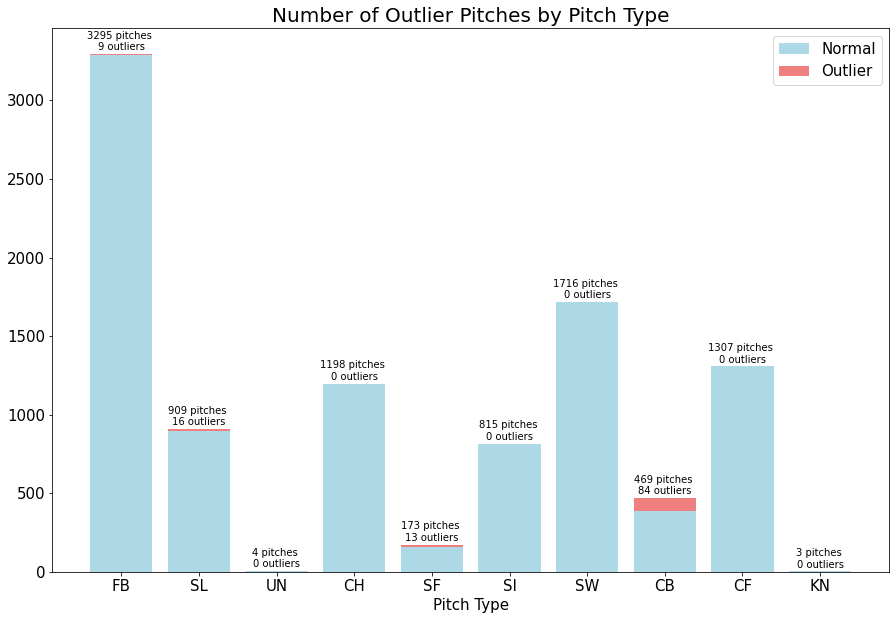

In [17]:
fig, ax=plt.subplots(figsize=(15,10))
ax.bar(pitch_types, normal_pitches, color='lightblue')
ax.bar(pitch_types, outlier_pitches, bottom=normal_pitches, color='lightcoral')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(["Normal","Outlier"], fontsize=15)
plt.title("Number of Outlier Pitches by Pitch Type", fontsize=20)
plt.xlabel("Pitch Type",fontsize=15)

for i in range(len(pitch_types)):
    ax.text(pitch_types[i],normal_pitches[i]+outlier_pitches[i]+80, str(normal_pitches[i]+outlier_pitches[i])+ " pitches \n" + str(outlier_pitches[i])+ " outliers", ha='center', va="center", fontsize=10)

plt.show()

The bar chart clearly illustrates that curveballs are most prone to influence from above average dew points than any other pitch type. However, dew point generally does is not a major factor of influence on pitch trajectory

In [18]:
pitch_results=list(df["PITCH_RESULT_KEY"].unique())
normal_pitches=[len(df[(df["Is Outlier?"]==0)&(df["PITCH_RESULT_KEY"]==i)]) for i in pitch_results]
outlier_pitches=[len(df[(df["Is Outlier?"]==1)&(df["PITCH_RESULT_KEY"]==i)]) for i in pitch_results]

data={"Results":pitch_results,"Normal Pitches": normal_pitches, "Outlier Pitches":outlier_pitches}

df2=pd.DataFrame(data)
df2=df2.sort_values(by="Outlier Pitches", ascending=True)

pitch_results=df2["Results"].tolist()
normal_pitches=df2["Normal Pitches"].tolist()
outlier_pitches=df2["Outlier Pitches"].tolist()

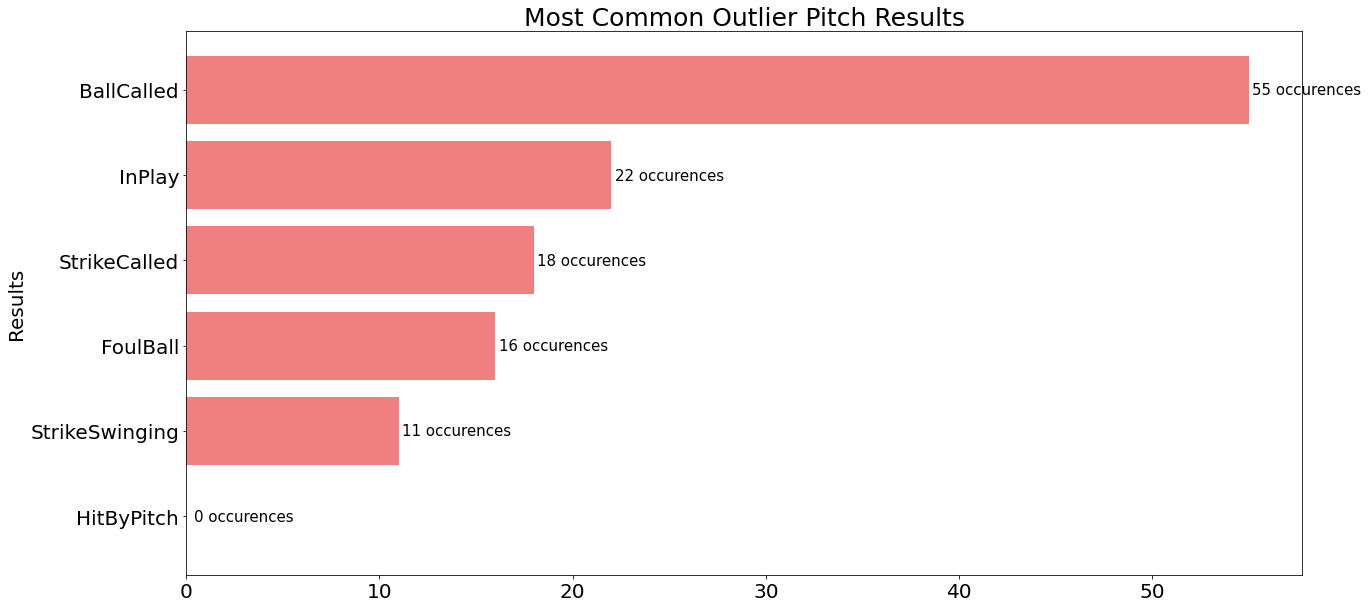

In [19]:
fig, ax=plt.subplots(figsize=(20,10))
ax.barh(pitch_results, outlier_pitches, color='lightcoral')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Most Common Outlier Pitch Results", fontsize=25)
plt.ylabel("Results",fontsize=20)

for i in range(len(pitch_results)):
    ax.text(outlier_pitches[i]+3,pitch_results[i],str(outlier_pitches[i])+ " occurences" , ha='center', va="center", fontsize=15)

plt.show()

Outlier pitches result in Ball Calls the most often. However, it's important to note that pitch results are also significantly influenced by the batter's performance. As such, we cannot definitely measure a correlation between dew point level and pitch result

## Part II: Preparing and Cleaning the Data

Now that we've identified which pitches were affected by dew points, we can build a classificaiton model that can calculate the probability that every pitch in the dataset was similarly affected. Before doing training the model, we need to clean the data that we'll be using.

Firstly, we'll drop attributes of the pitch do not pertain to the pitch's trajectory. In equal measure, attributes like EVENT RESULT and PITCH RESULT are also heavily influence by batter performance, and we therefore can not definitely define a correlation between these attributes and the influence of dew point. PITCH ID and PITCHER ID are only irrevelant because they are descriptive metadata, not characteristics of the pitch. Lastly, we remove PLATE_X and PLATE_Z because the insight we need from these attributes are represented in the IS OUTLIER? field

In [20]:
#Drop features irrelevant to pitch trajectory (ie. pitch identification tags, pitch outcomes)
df=df.drop(["PID", "PITCHER_KEY", "EVENT_RESULT_KEY","PITCH_RESULT_KEY","PLATE_X","PLATE_Z"],axis=1)

Our dataset now purely contains information about the pitches as it relates to the ball moving from the pitcher's to the moment it arrives at home plate. We retained characteristics like PITCH_NUMBER, BALLS, and IS_RUNNER_ON_1B to retain the circumstancial  elements of the game that could impact the pitcher's performance and his psyche and incorporate them into our model's calculations

In [21]:
df.isnull().any()

INNING_KEY                   False
BATTER_IN_INNING_KEY         False
PITCH_NUMBER                 False
OUT_KEY                      False
BALLS                        False
STRIKES                      False
IS_RUNNER_ON_1B              False
IS_RUNNER_ON_2B              False
IS_RUNNER_ON_3B              False
THROW_SIDE_KEY               False
PITCH_TYPE_TRACKED_KEY       False
INDUCED_VERTICAL_BREAK       False
HORIZONTAL_BREAK             False
SPIN_RATE_ABSOLUTE           False
RELEASE_SPEED                False
RELEASE_SIDE                 False
RELEASE_HEIGHT               False
RELEASE_EXTENSION            False
HORIZONTAL_APPROACH_ANGLE    False
VERTICAL_APPROACH_ANGLE      False
Is Outlier?                  False
dtype: bool

Our dataset does not have any missing values, so there is no work to be done in this regard. Let's move on to dummification of categorical variables and standardization

In [22]:
#Separate predictors from targets
x=df.iloc[:,0:20]
y=df["Is Outlier?"]

In [23]:
#Encode categorical variables
#Pitcher handedness (right vs. left)
x=pd.get_dummies(x,columns=["THROW_SIDE_KEY"],drop_first=True)

#Pitch type
x=pd.get_dummies(x, columns=["PITCH_TYPE_TRACKED_KEY"])

In [24]:
#Standardize features
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
x_std = std.fit_transform(x)
x=pd.DataFrame(x_std, columns=x.columns)

Before we can move on to model training, our dataset still has one major flaw: it is imbalanced.

In [25]:
df["Is Outlier?"].value_counts()

0.0    9767
1.0     122
Name: Is Outlier?, dtype: int64

We can clearly observe that there is the number of pitches unaffected by dew point vastly outnumber those that are; there are over 9700 unaffected pitches and only 122 affected pitches (outliers). There is clearly an imbalance in our data. More specifically, our dataset suffers from undersampling. Not resolving this issue before training our classification model will result in a model with a high level of bias towards the unaffected pitches, and will therefore yield inaccurate calculations. In balancing the data, we need to make sure the number of each class is equally represented in the dataset. That said, it is important that we do so without removing important information from the dataset. That's why, to remedy our imbalanced data, we'll use the approach of creating more casses of the minority class rather than eliminating cases of the majority class. We can achieve this using SMOTE

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

Resample dataset shape Counter({0.0: 9767, 1.0: 9767})


<AxesSubplot:title={'center':'New Distribution of Target Values'}>

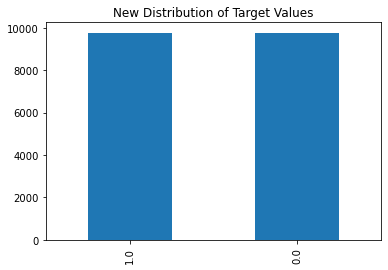

In [27]:
from collections import Counter

print(f'Resample dataset shape {Counter(y_resampled)}')
y_resampled.value_counts().plot(kind='bar', title='New Distribution of Target Values')

In [28]:
#Split into train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

## Part III: Model Training

There are many machine learning that we can use to perform binary classification, and each can be configurated with a variety of hyperparameters to optimize its accuracy. Support Vector Machines and Random Forests are examples of models that are great for performing binary classificaiton. However, our use case is more interested in predicting the probability of an sample being assigned a certain class rather than a definitive classification. A Logistic regression model is best suited for this goal.

A Logistic regression model works being using the logarithm of odds to estimate the probability of class first and foremost. The actual classification is based on how close the probability of a the positive class ("1") is to 0% or 100%.

In [29]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(x_train, y_train)

C:\Users\rprat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
#Find optimal parameters with hyperparameter tuning
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Define possible parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Test all configurations of parameters with grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

#Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.963066 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.963066 (0.004869) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.963042 (0.004866) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.962969 (0.004909) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.962920 (0.004867) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.962944 (0.004823) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.962920 (0.004900) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.962749 (0.005109) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.962823 (0.005089) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.962140 (0.005572) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.959166 (0.005093) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.959166 (0.005093) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.957654 (0.005498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.937029 (0.006223) wit

In [31]:
#Train model with optimal parameters
lr_model=LogisticRegression(penalty="l2", solver="newton-cg",C=100)
lr_model.fit(x_train, y_train)

LogisticRegression(C=100, solver='newton-cg')

In [32]:
lr_predictions=lr_model.predict(x_test)

In [33]:
#Evaluate model performance
from sklearn import metrics
lr_confusion_matrix=pd.DataFrame(metrics.confusion_matrix(y_test, lr_predictions, labels=[0,1]), index=['True Normal', 'True  Outlier'], columns=['Predicted Normal', 'Predicted Outlier'])
lr_confusion_matrix

,Predicted Normal,Predicted Outlier
True Normal,2798,153
True Outlier,55,2855


In [34]:
lr_accuracy=metrics.accuracy_score(y_test, lr_predictions)
lr_precision=metrics.precision_score(y_test, lr_predictions)
lr_recall=metrics.recall_score(y_test, lr_predictions)
lr_f1=metrics.f1_score(y_test, lr_predictions)

In [35]:
#Test the model again with different samples from the dataset using cross-fold validation
from sklearn.model_selection import train_test_split, cross_val_score

lr_scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring='accuracy')

lr_mean_accuracy = lr_scores.mean()
std_accuracy = lr_scores.std()

In [36]:
lr_performance_summary=pd.DataFrame([lr_accuracy,lr_precision,lr_recall,lr_f1,lr_mean_accuracy],index=["Accuracy","Precision","Recall","F1", "5-Fold CV Mean Accuracy"],columns=["Logistic Regression"])
lr_performance_summary

,Logistic Regression
Accuracy,0.964511
Precision,0.949136
Recall,0.981100
F1,0.964853
5-Fold CV Mean Accuracy,0.962554


Our Logistic regression model is very strong, with an accuracy score of about 96%. The model's precision and recall levels are also very good. The recall score indicates that the model was able to identify a 98% the positive classes that were in the dataset, and the precision score indicates that 95% of the positive cases that it did identify were correctly identified.

## Part IV: Final Predictions

Having trained a strong model, we can now apply it across all our data and format the final output

In [37]:
#Reintroduce the data
df=pd.read_csv("C:/Users/rprat/OneDrive/Documents/Interview Projects/Cincinnarti Red Associate Data Analyst Trainee Interview/data.csv")

In [38]:
#Reapply preprocessing
df_pid=pd.DataFrame(df["PID"])#preserve pitch id's
df=df.drop(["PID", "PITCHER_KEY", "EVENT_RESULT_KEY","PITCH_RESULT_KEY","PLATE_X","PLATE_Z"],axis=1)

#Encode categorical variables
#Pitcher handedness (right vs. left)
df=pd.get_dummies(df,columns=["THROW_SIDE_KEY"],drop_first=True)

#Pitch type
df=pd.get_dummies(df, columns=["PITCH_TYPE_TRACKED_KEY"])

#Standardize
std=StandardScaler()
df_std = std.fit_transform(df)
df=pd.DataFrame(df_std, columns=df.columns)

In [39]:
#Calculate probabilities and build a dataframe
df_probabilities=pd.DataFrame(lr_model.predict_proba(df))

In [40]:
#Format final output

#Remember that 1 indicates the pitch is an outlier, ie. it was affected by dew point
#We only want the probability of a 1 occurence
df_probabilities=df_probabilities.drop(columns=[0]) 

df_probabilities=df_probabilities.rename(columns={1:"DEWPOINT_AFFECTED"})

df_probabilities=df_probabilities.round(2)

#Add back pitch id's
final_df=pd.concat([df_pid,df_probabilities],axis=1)
final_df

,PID,DEWPOINT_AFFECTED
0,197,0.18
1,348,0.17
2,1072,0.02
3,420,0.03
4,198,0.00
...,...,...
9884,22663,0.11
9885,28642,0.00
9886,22664,0.15
9887,22665,0.00


In [41]:
#Export
from pathlib import Path

#Add your file path below
file_path=Path("C:/Users/rprat/OneDrive/Documents/Interview Projects/Cincinnarti Red Associate Data Analyst Trainee Interview/submission.csv")
final_df.to_csv(file_path)